In [15]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../data/Taitanic_data/data.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# 数据预处理

In [4]:
# 删除缺失值过多或者没有太大意义的数据
data.drop(['Cabin', 'Name', 'Ticket'], inplace=True, axis=1)

# 填充缺失值，用年龄均值进行预测
data['Age'] = data['Age'].fillna(data['Age'].mean())
data = data.dropna()

# 将分类变量转换为数值型变量

#将二分类变量转换为数值型变量
#astype能够将一个pandas对象转换为某种类型,和apply(int(x))不同,astype可以将文本类转换为数字,用这个方式可以很便捷地将二分类特征转换为0~1

data['Sex'] = (data["Sex"] == "Male").astype("int")

# 将三分类变量转换为数值型变量
labels = data["Embarked"].unique().tolist()
data["Embarked"] = data["Embarked"].apply(lambda x : labels.index(x))

data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0
1,2,1,1,0,38.0,1,0,71.2833,1
2,3,1,3,0,26.0,0,0,7.9250,0
3,4,1,1,0,35.0,1,0,53.1000,0
4,5,0,3,0,35.0,0,0,8.0500,0


# 提取特征和标签，区分训练集与测试集

In [5]:
x = data.iloc[:, data.columns != "Survived"]
y = data.iloc[:, data.columns == "Survived"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# 修正测试集和训练集的索引，防止混乱
for i in [x_train, x_test, y_train, y_test]:
    i.index = range(i.shape[0])

x_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,501,3,0,17.000000,0,0,8.6625,0
1,561,3,0,29.699118,0,0,7.7500,2
2,83,3,0,29.699118,0,0,7.7875,2
3,507,2,0,33.000000,0,2,26.0000,0
4,198,3,0,42.000000,0,1,8.4042,0


# baseline

In [6]:
clf = DecisionTreeClassifier(random_state=25)
clf = clf.fit(x_train, y_train)
score_ = clf.score(x_test, y_test)
score_

0.6067415730337079

In [9]:
score = cross_val_score(clf, x, y, cv=10).mean()
score

0.5995020429009192

# 在不同的maxdepth下观察拟合情况

0.7030260469867211


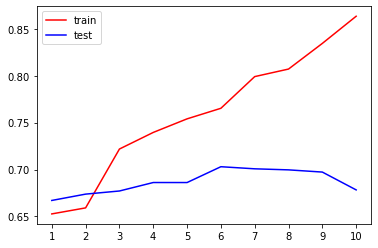

In [13]:
tr = []
te = []
for i in range(10):
    clf = DecisionTreeClassifier(random_state=25
                                 ,max_depth=i+1
                                 ,criterion="entropy"
                                )
    clf = clf.fit(x_train, y_train)
    score_tr = clf.score(x_train,y_train)
    score_te = cross_val_score(clf,x,y,cv=10).mean()
    tr.append(score_tr)
    te.append(score_te)
    
print(max(te))
plt.plot(range(1,11),tr,color="red",label="train")
plt.plot(range(1,11),te,color="blue",label="test")
plt.xticks(range(1,11))
plt.legend()
plt.show()

# 使用网格搜索调整参数

In [16]:
parameters = {'splitter':('best', 'random'),
             'criterion':("gini", "entropy"),
             "max_depth":[*range(1,10)],
             'min_samples_leaf':[*range(1,50,5)],
             'min_impurity_decrease':[*np.linspace(0,0.5,20)]
             }
clf = DecisionTreeClassifier(random_state=25)
GS = GridSearchCV(clf, parameters, cv = 10)
GS.fit(x_train, y_train)
GS.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 6,
 'splitter': 'random'}

In [17]:
GS.best_score_

0.7219918074756785